In [ ]:
#import spacy.cli
#spacy.cli.download("en_core_web_sm")

In [1]:
#Modules for data preprocessing
import pandas as pd
from scipy.sparse import hstack
import spacy
import re
nlp = spacy.load("en_core_web_sm")
nlp.Defaults.stop_words -= {"not", "do"}

C:\Users\Matthew\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Forming a dataframe
import sqlite3

# Connect to the database file
conn = sqlite3.connect("IMDB_Movies_2021.db")

# Create a cursor object
cursor = conn.cursor()

# Replace 'your_table_name' with the actual table name
table_name = "REVIEWS"

# Read the table into a DataFrame
df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)

# Close the connection
conn.close()

# Learn about the data and remove null rows

In [3]:
df.info()
df.shape
df.columns
df.describe()
df.isnull().sum()
df = df.dropna()
df["RATING"].value_counts()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5450 entries, 0 to 5449
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      5450 non-null   int64  
 1   REVIEW  5450 non-null   object 
 2   RATING  5332 non-null   float64
 3   AUTHOR  5450 non-null   object 
 4   TITLE   5450 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 213.0+ KB


ID        0
REVIEW    0
RATING    0
AUTHOR    0
TITLE     0
dtype: int64

# Now preprocess

In [4]:
def preprocess(text):
    doc = nlp(text)
    
    no_stop_words = [
        token.lemma_
        for token in doc
        if (
            not token.is_stop  # Remove stop words
            and not token.is_punct  # Remove punctuation
            and token.is_alpha  # Remove numbers, symbols
            and len(token.lemma_) > 2  # Remove short words
            and token.pos_ != "PROPN"  # Remove proper nouns
            and not re.match(r"https?://|www\.", token.text)  # Remove URLs
        )
    ]
    
    return " ".join(no_stop_words)

In [5]:
df["FIXED_REVIEW"] = df["REVIEW"].apply(preprocess)

# Now create a BOW

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

v = CountVectorizer()

bow = v.fit_transform(df.FIXED_REVIEW.values)

In [7]:
bow.toarray().shape

(5332, 12891)

# Here we categorise rating

In [22]:
#Here we categorise our ratings
def label_race(row):
    if row['RATING'] >= 7:
        return 'P'
    if row['RATING'] <=3:
        return 'N'
    else:
        return 'M'

df['CLASS'] = df.apply(label_race, axis=1) 

# Feature selection methods

In [50]:
#For correlation based ranking

def correlation(bow):
    new_corr_df = pd.DataFrame(bow.toarray())
    new_corr_df['target'] = pd.Series(df['RATING'])
    target_series = pd.Series(df['RATING'])
    corr_matrix = new_corr_df.corrwith(target_series)
    return corr_matrix

def best_k(corr_matrix,k,bow):
    new_corr_df = pd.DataFrame(bow.toarray())
    top_k = corr_matrix.abs().sort_values(ascending=False)[1:k].index.tolist()
    selected_features = new_corr_df[top_k]
    return(selected_features)

In [51]:
#Deafault of the whole BOW

In [52]:
#Chi squared based
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

def chi(bow,df,k):
    # N features with highest chi-squared statistics are selected
    chi2_features = SelectKBest(chi2, k = k)
    X = chi2_features.fit_transform(bow, df['RATING'])
    return(X)

# Now models

In [53]:
#Import packages
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB

## This uses Gaussian naive bayes (GNB)

In [54]:
def naive_Gauss_score(selected_features,df):
    X_train, X_test, y_train, y_test = train_test_split(selected_features, df['CLASS'], test_size=0.2, random_state=27)
    model = GaussianNB()
    model.fit(X_train, y_train)
    return model.score(X_test,y_test)

## This uses Multinomial naive bayes (MNB)

In [78]:
def naive_Multi_score(selected_features,df):
    X_train, X_test, y_train, y_test = train_test_split(selected_features, df['CLASS'], test_size=0.2, random_state=27)
    model = MultinomialNB()
    model.fit(X_train, y_train)
    return model.score(X_test,y_test)

# Now test and find optimal features

In [70]:
def test_model(start,stop,step,df,model,fs, bow):
    values = []
    
    
    if fs == 0:
        selected_features = pd.DataFrame(bow.toarray())
        if model == 'GNB':
                return(naive_Gauss_score(selected_features,df))
        if model == 'MNB':
            return naive_Multi_score(selected_features,df)
   
    if fs == 'correlation':
                corr_matrix = correlation(bow) 
    
    
    if model == 'GNB':
        for i in range(start,stop,step):
            if fs == 'correlation':
                selected_features = best_k(corr_matrix,i,bow)
            if fs == 'chi':
                selected_features = chi(bow,df,i).toarray()
            values.append(naive_Gauss_score(selected_features,df))
    
    
    if model == 'MNB':
        for i in range(start,stop,step):
            if fs == 'correlation':
                selected_features = best_k(corr_matrix,i,bow)
            if fs == 'chi':
                selected_features = chi(bow,df,i).toarray()
            values.append(naive_Multi_score(selected_features,df))
    
    
    plt.plot(range(start,stop,step),values)
    plt.show()
    maxi = max(values)
    index = values.index(maxi)*step + start
    return (maxi,index)

# Here we test different variations

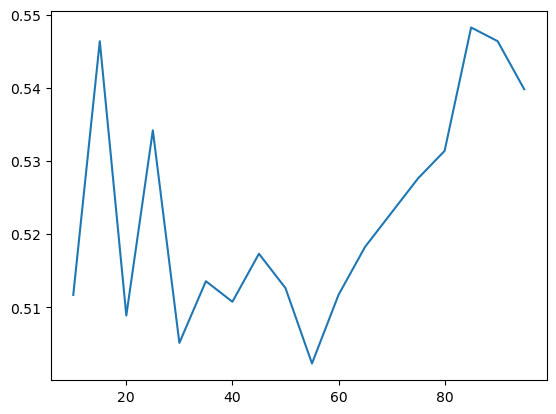

(0.5482661668228679, 85)

In [23]:
#Correlation and Gaussian Naive Bayes
test_model(10,100,5,df,'GNB','correlation',bow)

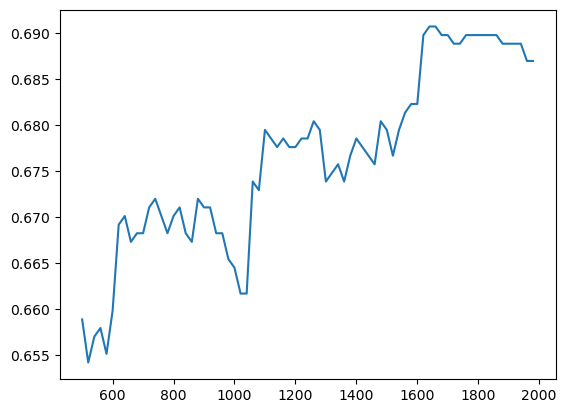

(0.6907216494845361, 1640)

In [26]:
#Correlation and Multinomial Naive Bayes
test_model(500,2000,20,df,'MNB','correlation',bow)

In [35]:
#No FS and Gaussian Naive Bayes
test_model(10,100,5,df,'GNB',0,bow)

0.4592314901593252

In [36]:
#No FS and Multinomial Naive Bayes
test_model(10,100,5,df,'MNB',0,bow)

0.7150890346766635

In [77]:
#Chi-square FS and multinomial bayes
test_model(10,12000,50,df,'MNB','chi',bow)

AttributeError: 'MultinomialNB' object has no attribute 'accuracy_score'

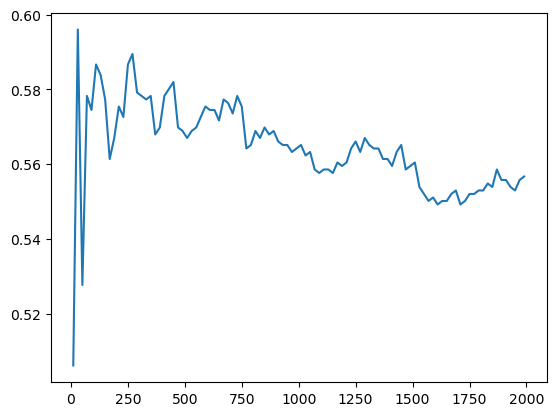

(0.5960637300843487, 30)

In [74]:
#Chi-square FS and Gaussian bayes
test_model(10,2000,20,df,'GNB','chi',bow)

# Then after finding the optimal K, we can retrain and calculate our performance metrics